# Causal probabilistic programming without tears

Despite the tremendous progress over the last several decades in reducing
causal inference to statistical practice, the \"causal revolution\"
proclaimed by Judea Pearl and others remains incomplete, with a sprawling and
fragmented literature inaccessible to non-experts and still somewhat
isolated from cutting-edge machine learning research and software tools.

Functional probabilistic programming languages are promising substrates for bridging this gap thanks to the close correspondence between their operational semantics and the field’s standard mathematical formalism of structural causal models. 

In this tutorial we elaborate on this idea with three key observations inspiring Causal Pyro's design, and outline a causal Bayesian workflow for using Causal Pyro to answer causal questions.

## Observation 1: causal models are probabilistic programs

Probabilistic programmers typically think of their code as defining a
probability distribution over a set of variables, but programs often contain
more information than just the joint distributions they induce. In practice,
when we write probabilistic programs in languages like Pyro we often bring
to bear knowledge of causal relationships between variables, and implicitly,
how changes to one variable would propagate to changes in others.

Formally, a causal model specifies a *family* of probability
distributions, indexed by a set of *interventions*. An intervention
represents a hypothetical change to the domain, under which we'd
expect the joint distribution over the variables of interest to change.

To ground this out a bit more concretely, consider the following Pyro program
describing the joint distribution over three random variables, *stress*, *smokes*,
and *cancer*. We'll call this model an `observational_model` for reasons that will
become apparent when we want to reason about cause and effect later.

In [1]:
import pyro
import torch
from pyro.distributions import Bernoulli

def observational_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

Our `observational_model` takes as input three sets of parameters, here just marginal and conditional probability tables, 
and returns a sample from the joint distribution over a single individual's *stress*, *smokes*, and *cancer* attributes.

Using Pyro's `plate` effect handler, we can easily sample repeatedly from the `observational_model`
to yield a joint distribution of an entire population of individual's attributes. For now we'll just 
choose some parameters by hand, but later we'll see how we can place priors over these parameters and then
use Pyro's support for approximate inference to infer likely parameters from data.

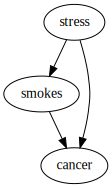

In [2]:
stress_pt = torch.tensor([0.5])
smokes_cpt  = torch.tensor([0.2, 0.8])
cancer_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

n_individuals = 10000
with pyro.plate("individuals", n_individuals, dim=-1):
    stress_obs, smokes_obs, cancer_obs = observational_model(stress_pt, smokes_cpt, cancer_cpt)

pyro.render_model(observational_model, (stress_pt, smokes_cpt, cancer_cpt))

Let's pretend for a moment that we're only interested in the relationship between whether individuals smoke
and how likely they are to get cancer. To understand this relationship a bit better, we can visualize the simulation from our model.

[Text(0.5, 1.0, 'Observational Data')]

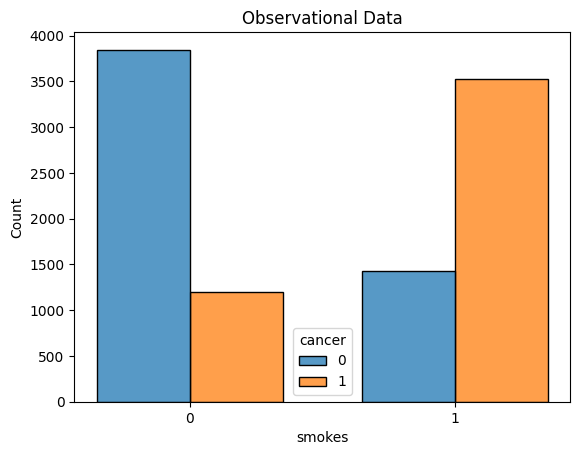

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data_obs = torch.concat((stress_obs.reshape(-1, 1), smokes_obs.reshape(-1, 1), cancer_obs.reshape(-1, 1)), axis=-1)

frame_obs = pd.DataFrame(data_obs.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs).set(title='Observational Data')

As we can see clearly, our model tells us that individuals who smoke are much more likely to get cancer than individuals
who don't. Of the ~7,000 simulated individuals who don't smoke only ~500 got cancer, roughly 7% of the non-smokers. Of the 
remaining ~3,000 simulated individuals who did smoke ~1,000 individuals got cancer, a much high 33% of the smoking population.

(TODO: edit these numbers once parameters are finalized. They've already drifted from the figures because I was playing with parameters to tell the story.)

So far we have a program that describes the distribution over data given model parameters. 
Somewhat more abstractly, we can imagine this process of simulating from a model as we've done above
with the following (somewhat cartoonish) diagram. Here, each point in "model space" or "parameter space"
induces a joint distribution over data.

(TODO: replace SCM with "program" and change colors a bit.)

![title](figures/Conditional_Distribution_of_Data.png)

Simulating from our `observational_model` is certainly interesting and (perhaps) informative, but it doesn't exactly give us answers to what what we're interested in. Instead, we want to
know to what extent smoking *causes* cancer, not just it's predictive ability. To answer this question, we can instead
sample from modified versions of our model in which individuals are forced to smoke or not smoke, regardless of their level of stress. We can instatiate these thought experiments
as new programs in our probabilistic programming language.

To ground this out a bit more concretely, consider the following two new Pyro programs; 
`always_smokes_model` and `never_smokes_model`, which closely resemble our original `observational_model` except 
in how the *smokes* attribute is assigned. Specifically, we've replaced the expression `smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress])).long()`
with the expressions `smokes   = pyro.deterministic("smokes", torch.ones_like(stress))` and `smokes   = pyro.deterministic("smokes", torch.zeros_like(stress))` respectively.
In other words, we set the *smokes* variable to be either $1$ or $0$ regardless of the individual's stress.

In [4]:
def always_smokes_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", torch.ones_like(stress))
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

def never_smokes_model(stress_pt, smokes_cpt, cancer_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    # smokes no longer depends on stress.
    smokes   = pyro.deterministic("smokes", torch.zeros_like(stress))
    cancer   = pyro.sample("cancer", Bernoulli(cancer_cpt[stress, smokes])).long()

    return stress, smokes, cancer

# Let's pretend that we force half the people to always smoke and half to never smoke.
n_counterfactual_individuals = int(n_individuals/2)
with pyro.plate("counterfactual_individuals", n_counterfactual_individuals, dim=-1):
    # Sample from a population of individuals under the "always smokes" thought experiment.
    stress_as, smokes_as, cancer_as = always_smokes_model(stress_pt, smokes_cpt, cancer_cpt)
    stress_ns, smokes_ns, cancer_ns = never_smokes_model(stress_pt, smokes_cpt, cancer_cpt)

Let's visualize a simulation from these new programs and compare against our original simulation.

[Text(0.5, 1.0, 'Thought Experiment')]

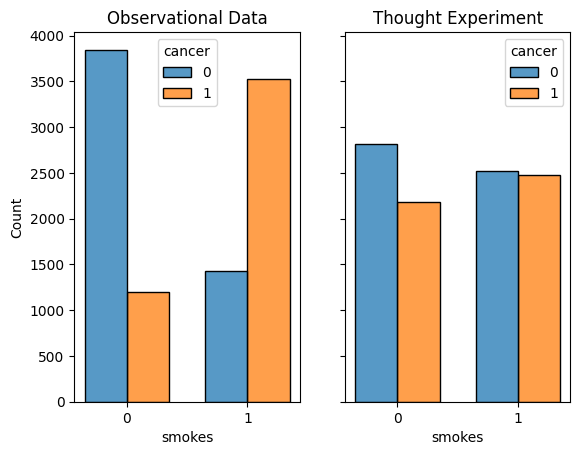

In [5]:
data_as = torch.concat((stress_as.reshape(-1, 1), smokes_as.reshape(-1, 1), cancer_as.reshape(-1, 1)), axis=-1)
data_ns = torch.concat((stress_ns.reshape(-1, 1), smokes_ns.reshape(-1, 1), cancer_ns.reshape(-1, 1)), axis=-1)
data_int = torch.concat((data_as, data_ns))

frame_int = pd.DataFrame(data_int.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})

_, ax = plt.subplots(1, 2, sharey=True)

sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs, ax=ax[0]).set(title='Observational Data')
sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_int, ax=ax[1]).set(title='Thought Experiment')


Using our intervened models we can clearly see that changing the mechanism by which individuals
choose whether or not to smoke dramatically changes the joint distribution between smoking and cancer. In our observational model
individuals who smoke are much more likely to get cancer than those who don't smoke. However, in our modified model in which individuals
are forced to smoke or not smoke, the dependence between smoking and cancer nearly disapears.

This phenomenon we're observing in this (contrived) example is known as confounding. Here, the reason we see a statistical dependency between
smoking in cancer in our observational model is because of the individuals' stress. Individuals who are stressed are more likely to smoke, and stress
causes an increase in cancer. The confounding effect of stress dissapears in our intervened programs, as stress no longer influences whether individuals smoke or not.

Before we move on, let's be a bit more precise about the causal query we'd like to answer. One quantity we may wish to estimate is how much, on average, smoking increases the risk of cancer.
We can define this *average treatment effect* mathematically as the difference between the proportion of individuals who get cancer under our `always_smokes_model` and our `never_smokes_model`.
Again, we can easily write this as code.

In [6]:
effect = cancer_as.float().mean() - cancer_ns.float().mean()
effect

tensor(0.0586)

So far, we've defined a model describing how data is generated in the actual world we can observe, which we called `observational_model`, and then transformed
our original model to represent our thought experiments, or interventions, which we called `always_smokes_model` and `never_smokes_model`. Then, we sampled
from our original and transformed models to generate simulated outcomes, and finally summarized the simulated outcomes yielding an answer to our causal query. Again,
this process can be viewed somewhat abstractly as follows:

![title](figures/Interventional_Conditional.png)


One of the key insights behind Causal Pyro (and borrowed from Pearl's structural formalism) is that these kinds of interventions can be formalized as model agnostic
program transformations, i.e. a function $I: \mathcal{P} \rightarrow \mathcal{P}$, where $\mathcal{P}$ is the space of programs in our language.

Thusfar we've accomplished some limited form of causal reasoning by manually rewriting our original program, replacing the mechanism for how individuals choose to smoke directly in Pyro's syntax, and then simulating from the new programs.
This is a perfectly reasonable thing to do in these kinds of simple scenarios where we have a single model and a single "thought experiment" we want to explore. However, as we'll see throughout these tutorials and examples,
reasoning about cause and effect can often involve much more involved program transformations than this simple example. For example, in our mediation analysis example (TODO: add pointer to example) we'll need to simulate
multiple counterfactual models simultaneously, with intervention assignments in one model that depend on simulated outcomes in another. 

Instead, Causal Pyro addresses the complexity of causal reasoning by automating a number of probabilistic program transformations; including
interventions, construction of counterfactual worlds, and (as we'll see in subsequent tutorials) automatic reparameterization for counterfactual or "what if" reasoning. 

For example, we can much more implement `always_smokes_model` and `never_smokes_model` succinctly as follows, using Causal Pyro's `do` program transformation.
This special function `do` takes as input a probabilistic program and a dictionary describing the intervention assignment and returns a transformed probabilistic program with the intervention applied.

In [7]:
from causal_pyro.query.do_messenger import do

always_smokes_model = do(observational_model, {"smokes": torch.tensor([1.])})
never_smokes_model  = do(observational_model, {"smokes": torch.tensor([0.])})

Just like our original implementation of `always_smokes_model` and `never_smokes_model`, these transformed models are probabilistic programs in Pyro, and can thus freely compose with all of Pyro's effect handlers.
For example, we can again use an `plate` effect handler to sample from a population of individuals.

In [8]:
with pyro.plate("counterfactual_individuals", n_counterfactual_individuals, dim=-1):
    # Sample from a population of individuals under the "always smokes" thought experiment.
    stress_as, smokes_as, cancer_as = always_smokes_model(stress_pt, smokes_cpt, cancer_cpt)
    stress_ns, smokes_ns, cancer_ns = never_smokes_model(stress_pt, smokes_cpt, cancer_cpt)

effect = cancer_as.float().mean() - cancer_ns.float().mean()
effect

tensor(0.0554)

In this section we've seen that a probabilistic program specifies a causal model in that it
  1. specifies a "default" or "observational" joint distribution over the
variables of interest according to the usual semantics of probabilistic
programming languages
  2. encodes the necessary information to
determine the new joint distribution under an arbitrary intervention
(program transformation)---apply the transformation and derive the new
joint distribution.


## Observation 2: causal uncertainty is probabilistic uncertainty

So far we've shown how to define a causal model as a probabilistic program, and how to use Causal Pyro's intervention program transformations, `do`,
to answer causal questions. However, in doing so we made a few very strong assumptions.

1. We assumed that we knew the parameters of our causal model exactly, i.e. we asserted *how much* variables causally affect which other variables.
2. We assumed that we knew the structure of our causal model exactly, i.e. we asserted *which* variables causally affect which other variables.

In this section we'll show how we can use Causal Pyro to substantially relax these assumptions, representing broad uncertainty over causal structure and parameters.

Mathematically, the `observational_model` we defined previously can be thought of as a programatic representation of the conditional distribution $P(stress, smokes, cancer | \theta)$, where $\theta$ 
represents all of the parameters taken as arguments. To instead represent the joint distribution $P(stress, smokes, cancer, \theta)$ we can simply define a program representing the prior $P(\theta)$
and then call our `observational_model` using samples from the prior program as follows.

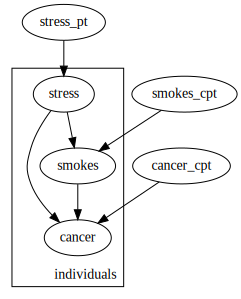

In [9]:
from pyro.distributions import Beta

def parameter_prior():

    stress_pt = pyro.sample("stress_pt", Beta(torch.ones(1), torch.ones(1)).to_event(1))
    smokes_cpt = pyro.sample("smokes_cpt", Beta(torch.ones(2), torch.ones(2)).to_event(1))
    cancer_cpt = pyro.sample("cancer_cpt", Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)) 

    return stress_pt, smokes_cpt, cancer_cpt

def bayesian_observational_model(n_individuals):
    stress_pt, smokes_cpt, cancer_cpt = parameter_prior()

    with pyro.plate("individuals", n_individuals, dim=-1):
        # Call our original observational_model with parameters sampled from our prior above.
        return observational_model(stress_pt, smokes_cpt, cancer_cpt)

pyro.render_model(bayesian_observational_model, (n_individuals,))

By repeatedly sampling from the observational model we can see how our new uncertainty about probability tables propagates to uncertainty about the relationship between smoking and cancer.

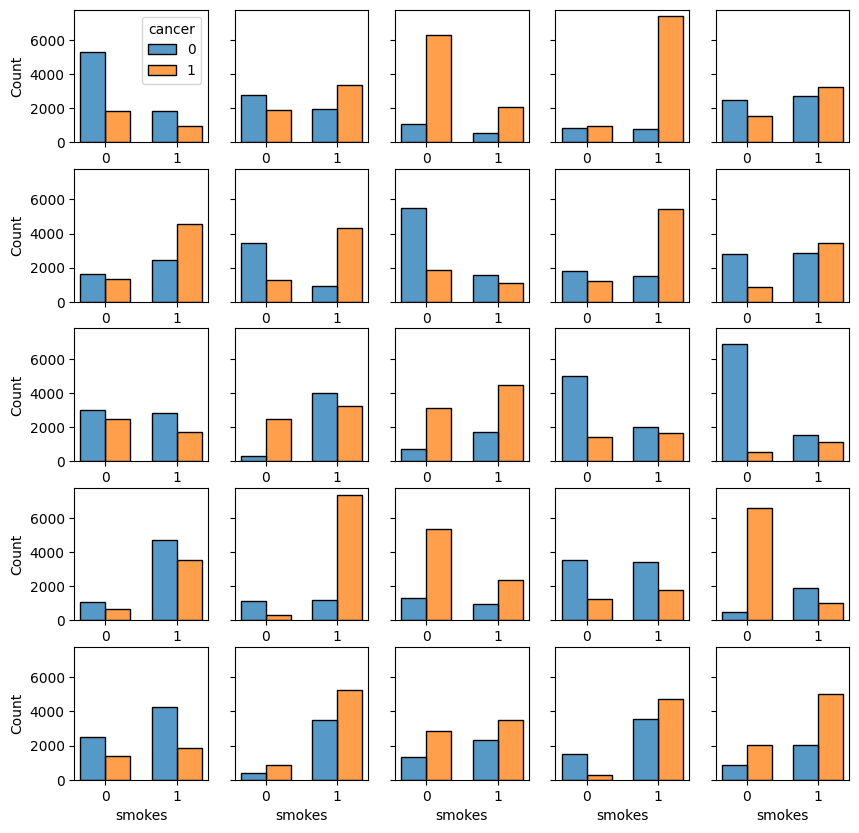

In [10]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_obs, smokes_obs, cancer_obs = bayesian_observational_model(n_individuals)

    data_obs = torch.concat((stress_obs.reshape(-1, 1), smokes_obs.reshape(-1, 1), cancer_obs.reshape(-1, 1)), axis=-1)
    frame_obs = pd.DataFrame(data_obs.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_obs, ax=ax[row, col], legend = (False if i else True))

Earlier we showed how to use Causal Pyro's `do` program transformation (implemented as an effect handler) to apply an intervention to our original `observational_model` that took known parameters as input.
It turns out that `do` and `plate` effect handlers commute and freely compose with nested probabilistic program function calls. In practice, this means that we
can easily (i) define interventions that are themselves parameterized by random choices, and (ii) apply our intervention to the Bayesian variant of our observational model above 
to generate a Bayesian variant of our intervened model with the same prior.

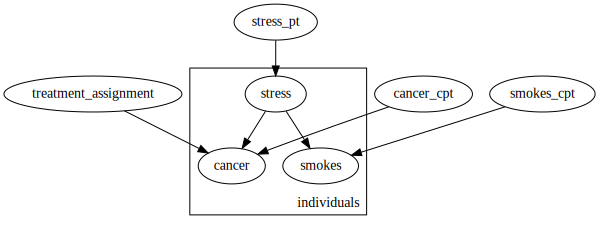

In [11]:
def randomized_intervention(model, intervention_variable, n_individuals):
    def new_model(*args, **kwargs):
        intervention_assignment = pyro.sample("treatment_assignment", Bernoulli(torch.ones(n_individuals) * 0.5).to_event(1)).long()
        return do(model, {intervention_variable: intervention_assignment})(*args, **kwargs)
    
    return new_model

bayesian_randomized_model = randomized_intervention(bayesian_observational_model, "smokes", n_individuals)

# TODO: explain this rendering a bit.
pyro.render_model(bayesian_randomized_model, (n_individuals,))

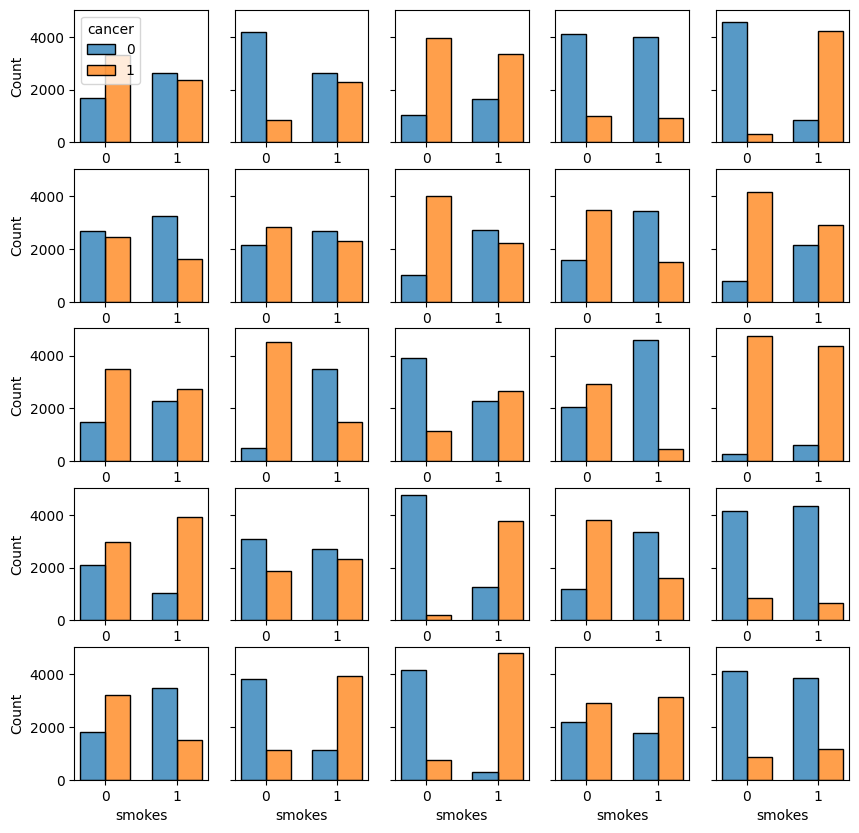

In [12]:
bayesian_randomized_model = randomized_intervention(bayesian_observational_model, "smokes", n_individuals)

# NOTE: It's not quite right to say that plates and intervention commute, as the intervention need to be over the full population (see torch.ones above vs. torch.tensor([1.]) previously)
# TODO: refine the language to be more precise (or acknowledge imprecession) about this point.

_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_r, smokes_r, cancer_r = bayesian_randomized_model(n_individuals)
    data_r = torch.concat((stress_r.reshape(-1, 1), smokes_r.reshape(-1, 1), cancer_r.reshape(-1, 1)), axis=-1)
    frame_r = pd.DataFrame(data_r.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_r, ax=ax[row, col], legend = (False if i else True))

In addition to adding prior distribution over model parameters given a known structure, we can further add uncertainty to our causal assumptions
by writing a probabilistic program that selects between multiple probabilistic programs depending on the result of a discrete random choice.
Again, we can quickly expand the complexity of our uncertain causal assumptions without needing to rewrite our original `observational_model` from scratch,
as probabilistic programs in Causal Pyro are compositional.

In the context of our original smoking example, let's pretend that we don't know whether smoking influences cancer, or whether cancer influences smoking.
(This might seem somewhat nonsensical now, but it could have been a "plausible" hypothesis 70 years ago.)
Graphically, this would be represented as uncertainty about the causal edge between 'smokes` and 'cancer' variables. To implement this uncertainty in Causal Pyro, we 
first need to write a new program that represents the alternative observational model.

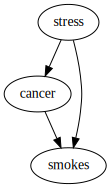

In [13]:
def observational_model_alt(stress_pt, cancer_cpt, smokes_cpt):
    stress = pyro.sample("stress", Bernoulli(stress_pt)).long()
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[stress])).long()
    smokes = pyro.sample("smokes", Bernoulli(smokes_cpt[stress, cancer])).long()

    return stress, smokes, cancer

stress_pt = torch.tensor([0.5])
cancer_cpt  = torch.tensor([0.2, 0.8])
smokes_cpt  = torch.tensor([[0.1, 0.15], 
                            [0.8, 0.85]])

pyro.render_model(observational_model_alt, (stress_pt, cancer_cpt, smokes_cpt))

Again, we can place a prior over parameters for this alternative model, representing our uncertainty about the strength of effects.

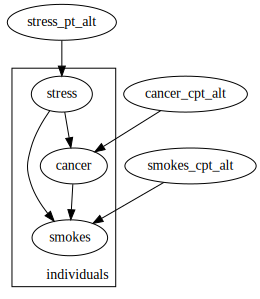

In [14]:
def parameter_prior_alt():

    stress_pt = pyro.sample("stress_pt_alt", Beta(torch.ones(1), torch.ones(1)).to_event(1))
    cancer_cpt = pyro.sample("cancer_cpt_alt", Beta(torch.ones(2), torch.ones(2)).to_event(1))
    smokes_cpt = pyro.sample("smokes_cpt_alt", Beta(torch.ones(2, 2), torch.ones(2, 2)).to_event(2)) 

    return stress_pt, cancer_cpt, smokes_cpt

def bayesian_observational_model_alt(n_individuals):
    stress_pt, cancer_cpt, smokes_cpt = parameter_prior_alt()

    with pyro.plate("individuals", n_individuals, dim=-1):
        # Call our original observational_model with parameters sampled from our prior above.
        return observational_model_alt(stress_pt, cancer_cpt, smokes_cpt)

pyro.render_model(bayesian_observational_model_alt, (n_individuals,))

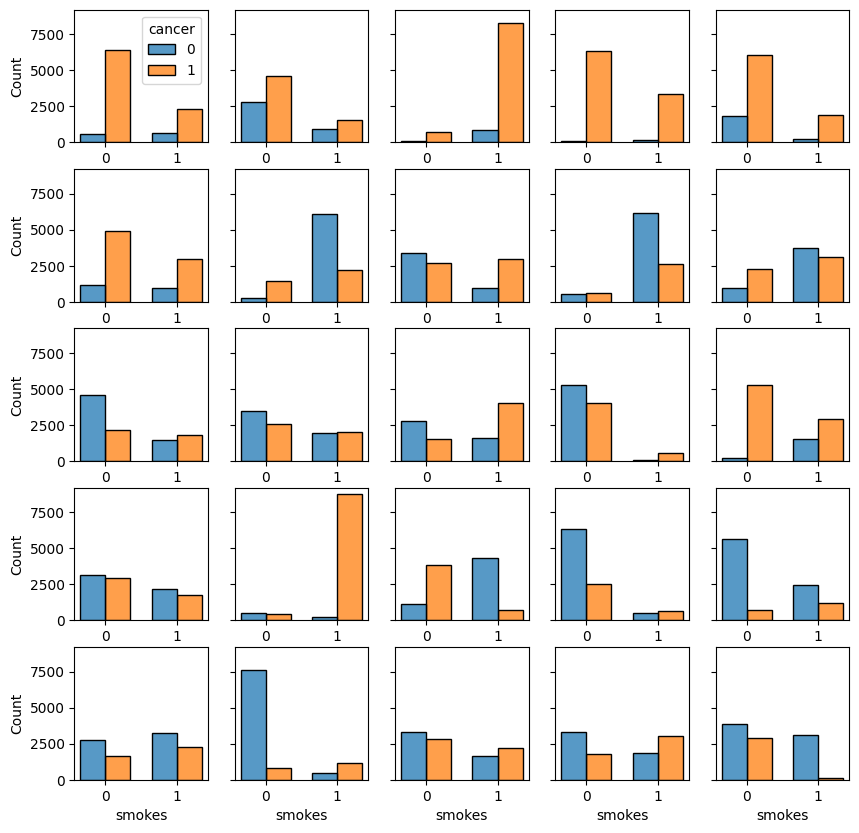

In [15]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_alt, smokes_alt, cancer_alt = bayesian_observational_model_alt(n_individuals)

    data_alt = torch.concat((stress_alt.reshape(-1, 1), smokes_alt.reshape(-1, 1), cancer_alt.reshape(-1, 1)), axis=-1)
    frame_alt = pd.DataFrame(data_alt.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_alt, ax=ax[row, col], legend = (False if i else True))

Looking at just samples from the observational distribution, this new alternative structure doesn't obviously result in a different joint distribution between smoking and cancer before applying an intervention. However, this will not be the case for the interventional distribution over random variables. In our new alternative candidate model, smoking has no effect on cancer whatsoever, and thus we shouldn't see any difference between cancer rates between individuals when smoking is randomized.

To see this conclusion visually, we can again apply an intervention to this new model and then simulate from the transformed model representing our thought experiment.

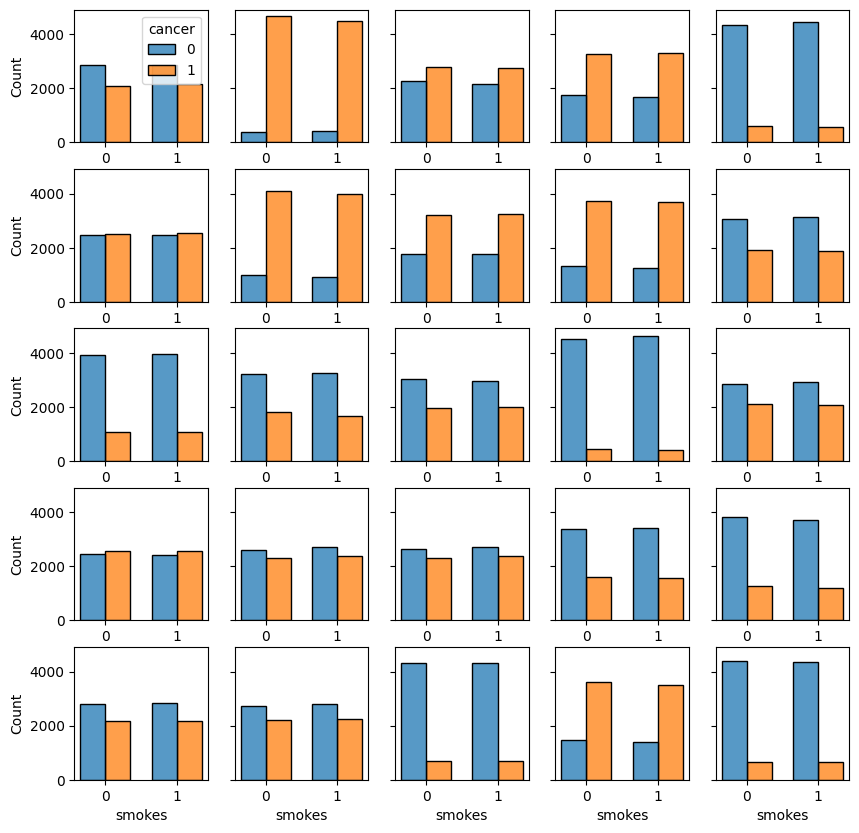

In [16]:
bayesian_randomized_model_alt = randomized_intervention(bayesian_observational_model_alt, "smokes", n_individuals)

# NOTE: It's not quite right to say that plates and intervention commute, as the intervention need to be over the full population (see torch.ones above vs. torch.tensor([1.]) previously)
# TODO: refine the language to be more precise (or acknowledge imprecession) about this point.

_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_r, smokes_r, cancer_r = bayesian_randomized_model_alt(n_individuals)
    data_r = torch.concat((stress_r.reshape(-1, 1), smokes_r.reshape(-1, 1), cancer_r.reshape(-1, 1)), axis=-1)
    frame_r = pd.DataFrame(data_r.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_r, ax=ax[row, col], legend = (False if i else True))

Using our two probabilistic programs representing different plausible structures (and with uncertain parameters), we can write a probabilistic program that randomly chooses between them. 
Conceptually, this represents a scenario where we don't know whether smoking causes cancer or cancer causes smoking.

In [17]:
from pyro.distributions import Bernoulli

def bayesian_observational_model_unknown_structure(n_individuals):
    
    is_original_model = pyro.sample("is_original_model", Bernoulli(0.5))
    model = bayesian_observational_model if is_original_model else bayesian_observational_model_alt

    return model(n_individuals)

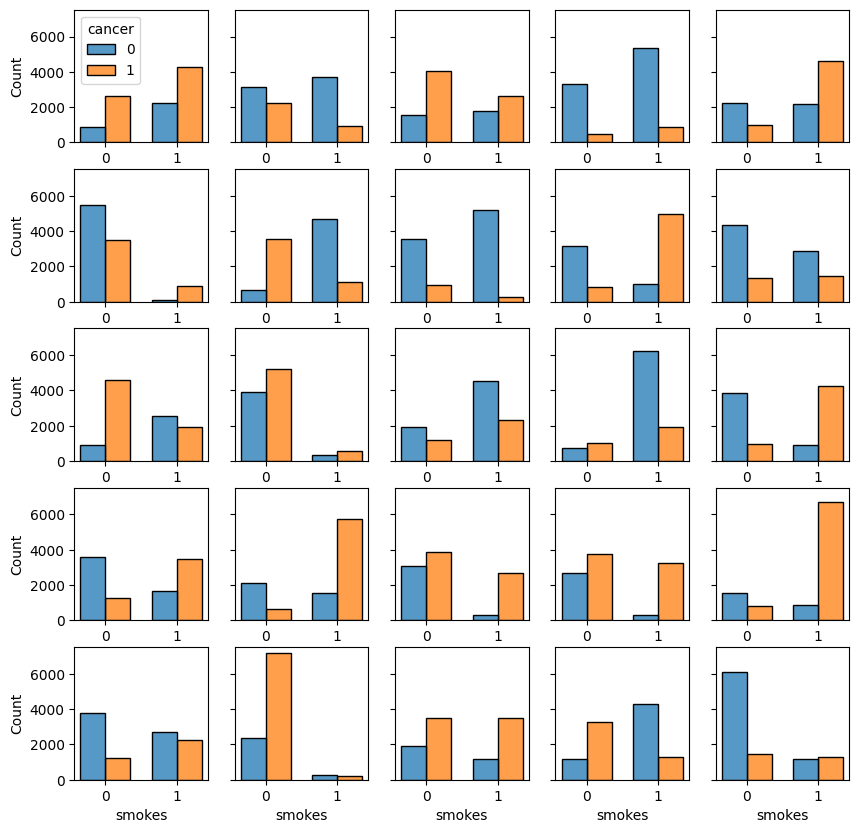

In [18]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_us, smokes_us, cancer_us = bayesian_observational_model_unknown_structure(n_individuals)

    data_us = torch.concat((stress_us.reshape(-1, 1), smokes_us.reshape(-1, 1), cancer_us.reshape(-1, 1)), axis=-1)
    frame_us = pd.DataFrame(data_us.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_us, ax=ax[row, col], legend = (False if i else True))

Earlier we showed that interventions in Casual Pyro compose freely with hierarchical Bayesian extensions of our original model with deterministic parameters.
Perhaps not surprisingly, interventions are still well-behaved even when applied to program with uncertainty over structure as well.

To see this, let's again apply our randomized intervention and visualize the results of repeated samples from our model with structural uncertainty. As expected, we see that some samples from this model with structural uncertainty show a difference in cancer rate between smokers and non-smokers (representing samples in which `is_original_model=1`)


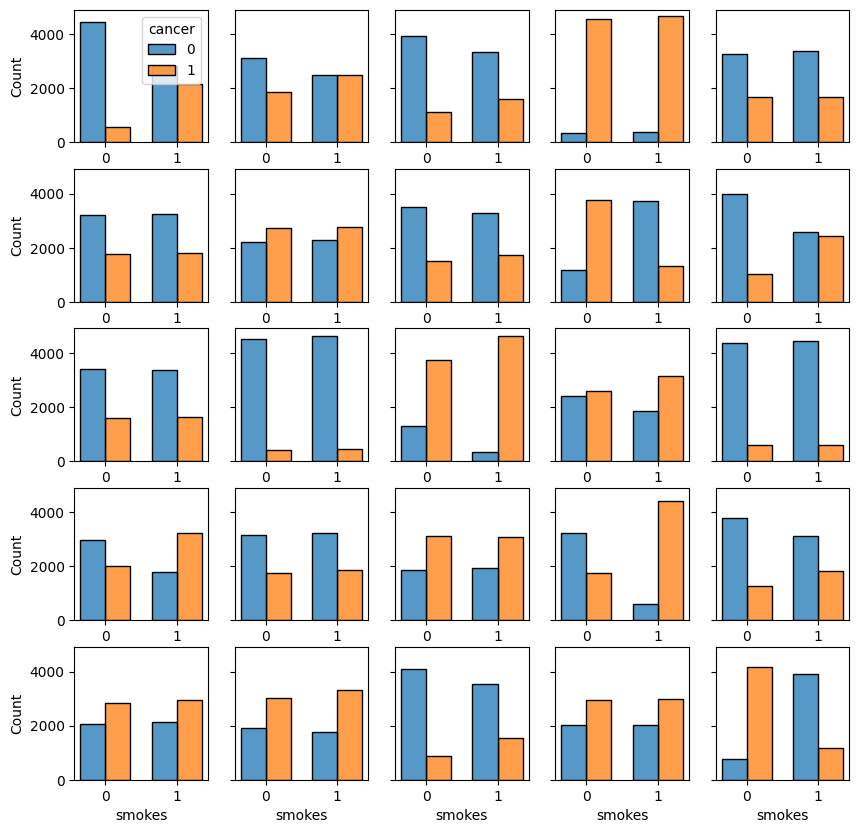

In [19]:
bayesian_randomized_model_unknown_structure = randomized_intervention(bayesian_observational_model_unknown_structure, "smokes", n_individuals)

# NOTE: It's not quite right to say that plates and intervention commute, as the intervention need to be over the full population (see torch.ones above vs. torch.tensor([1.]) previously)
# TODO: refine the language to be more precise (or acknowledge imprecession) about this point.

_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

for i in range(25):

    row = i % 5
    col = i // 5

    stress_r, smokes_r, cancer_r = bayesian_randomized_model_unknown_structure(n_individuals)
    data_r = torch.concat((stress_r.reshape(-1, 1), smokes_r.reshape(-1, 1), cancer_r.reshape(-1, 1)), axis=-1)
    frame_r = pd.DataFrame(data_r.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame_r, ax=ax[row, col], legend = (False if i else True))

Now that we've incorporated uncertainty about the structure *and* parameters, we can see that samples from the post-intervention
version of our program sometimes shows an effect of smoking on cancer and sometimes shows no effect. In other words, our uncertainty
over causal models naturally propagates to uncertainty over causal conclusions. We can visualize this flow of uncertainty in the following
(again somewhat cartoonish) diagram showing how information flows from observational probabilistic programs to interventions probabilistic programs
and subsequently to factual and counterfactual data.


![title](figures/Interventional_Marginal.png)

## Observation 3: causal inference is probabilistic inference


Thusfar we've seen how introducing intervention program transformations like `do` make it straightforward to model randomized experiments and to reason about the causal implications of (i) uncertainty over the strength of causal effects and (ii) uncertainty over causal structure.
We can call this progress *causal modeling*. In practice however, we often don't want to just posit causal knowledge about the world, we also want to update that knowledge in light of observational and experimental data. We'll call this
process of learning about cause and effect from data *causal inference*. The key insight underlying Causal Pyro is that taking a Bayesian approach to causal modeling as we've done thusfar means that causal inference simply reduces to 
probabilistic inference in what's known as a *multi-world* transformation of our original causal model. 

As we'll show in this section, to reduce causal inference to probabilistic inference we have to perform a few distinct steps:
- Transform our Causal Pyro program into a new Pyro program that represents a joint distribution over both factual outcomes, i.e. what actually happened, and counterfactual outcomes, i.e. what would have happened had we intervened. We'll call this a *twin world program*.
- Condition the factual outcomes in our twin world program according to some observed data.
- Run (approximate) posterior inference in the conditioned twin world program, resulting in an updated distribution over both parameters and counterfactual outcomes.

To see this more clearly, let's introduce another program transformation provided by Causal Pyro, the `TwinWorldCounterfactual` effect handler. Intuitively, this new effect handler tells Causal Pyro that any `pyro.sample` statements
that are downstream of an intervention should be sampled twice, once for the observable world without interventions and once for the counterfactual world with interventions applied.

In [20]:
from causal_pyro.counterfactual.handlers import TwinWorldCounterfactual

stress_r_sw, smokes_r_sw, cancer_r_sw = bayesian_randomized_model(n_individuals)

# TODO: note that we can apply the TwinWorldCounterfactual either as a context manager or as a higher order function.

with TwinWorldCounterfactual(dim=-2):
    stress_r_tw, smokes_r_tw, cancer_r_tw = bayesian_randomized_model(n_individuals)

print("Single World Stress Shape = {}".format(stress_r_sw.shape))
print("Single World Smokes Shape = {}".format(smokes_r_sw.shape))
print("Single World Cancer Shape = {}".format(cancer_r_sw.shape))
print("Twin World Stress Shape = {}".format(stress_r_tw.shape))
print("Twin World Smokes Shape = {}".format(smokes_r_tw.shape))
print("Twin World Cancer Shape = {}".format(cancer_r_tw.shape))

Single World Stress Shape = torch.Size([10000])
Single World Smokes Shape = torch.Size([10000])
Single World Cancer Shape = torch.Size([10000])
Twin World Stress Shape = torch.Size([10000])
Twin World Smokes Shape = torch.Size([2, 10000])
Twin World Cancer Shape = torch.Size([2, 10000])


Looking at the shapes of these tensors give a bit of intuition about how this `TwinWorldCounterfactual` transforms the execution of our `bayesian_randomized_model` representing a randomized experiment condition.

- All three of the tensors sampled from the `bayesian_randomized_model` without using the `TwinWorldCounterfactual` handler have the same size, `torch.Size([10000])`, where each element represents a distinct individual with an intervention applied.
- The returned `stress_r_mw` tensor using the `TwinWorldCounterfactual` is the same size as the version without the `TwinWorldCounterfactual` handler, `stress_r_sw`. This is because the `stress` variable is upstream of the intervened `smokes` variable, and is thus always identical in both factual and counterfactual worlds. Causal Pyro automates this reasoning.
- The returned `smokes_r_sw` and `cancer_r_sw` tensors using the `TwinWorldCounterfactual` handler has been expanded to a tensor of size `torch.Size([2, 10000])`, where `smokes_r_mw[0, :]` and `cancer_r_mw[0, :]` are sampled from the observational distribution and `smokes_r_mw[1, :]` and `cancer_r_mw[1, :]` are sampled from the interventional distribution. Here, the `dim` argument of the `TwinWorldCounterfactual` handler dictates which tensor dimension denotes the difference between observational and interventional distributions.

Using somewhat light and informal mathematical notation for brevity, the tensors returned from the model transformed using the `TwinWorldCounterfactual` handler represent samples from the joint distribution over $p(stress, smokes, cancer, stress_{cf}, smokes_{cf}, cancer_{cf})$, where $stress$, $smokes$, and $cancer$ are the random variables representing individual attributes without an intervention and $stress_{cf}$, $smokes_{cf}$, and $cancer_{cf}$ are the random variables representing individual attributes in our randomized experiment. However, as we mentioned before, causal inference is about coming to causal conclusions combining modeling assumptions *and* data, not just modeling assumptions along. However, now that we have a model representing a joint distribution over both observational and interventional data, we can condition our model and apply approximate inference techniques just as we would any other Pyro model. For example, using Pyro's support for stochastic variaitional inference we can obtain an approximate conditional distribution $p(stress_{cf}, smokes_{cf}, cancer_{cf}|stress, smokes, cancer)$.

To see how Causal Pyro enables causal inference, let's first generate some synthetic observational data for $smokes$ and $cancer$ in which approximately half of the individuals smoke, and those who do are much more likely to have cancer than those who don't. Importantly, here we'll assume that $stress$ is latent.

In [78]:
smokes_p  = torch.tensor([0.5])
cancer_cpt  = torch.tensor([0.2, 0.8])

with pyro.plate("n_individuals", n_individuals, dim=-1):
    smokes = pyro.sample("smokes", Bernoulli(smokes_p))
    cancer = pyro.sample("cancer", Bernoulli(cancer_cpt[smokes.long()]))

Now that we have synthetic data, we can condition on it inside of the `TwinWorldCounterfactual` handler we saw earlier. This creates a new model `twin_model_conditioned`, that represents the conditional distribution we're interested in, $p(stress_{cf}, smokes_{cf}, cancer_{cf}|stress, smokes, cancer)$.

In [79]:
twin_model_conditioned = TwinWorldCounterfactual(dim=-2)(pyro.condition(bayesian_randomized_model, data={"smokes":smokes, "cancer": cancer}))

After using the `TwinWorldCounterfactual` and the `do` handlers, the resulting model can be treated as an ordinary Pyro program. Just as in Pyro, conditioning a model on data means that we can no longer sample directly from the `twin_model_conditioned` model by just running the program; instead we need to run an *approximate inference algorithm*.

Thankfully, because we've used Causal Pyro's program transformations to construct an ordinary Pyro program, we can use Pyro's built-in support for approximate inference. To see this, let's run stochastic variational inference with enumeration over discrete variables using Pyro.

In [88]:
from pyro.poutine import trace, block
from pyro.infer.autoguide import AutoNormal, AutoDelta
from pyro.infer import SVI, config_enumerate

initial_lr = 0.03
adam = pyro.optim.Adam({'lr': initial_lr})
elbo = pyro.infer.TraceEnum_ELBO(num_particles=1)

guide = AutoNormal(block(twin_model_conditioned, hide=['treatment_assignment', 'stress', 'cancer_unobserved', 'stress_unobserved', 'smokes_unobserved']))
# guide = AutoDelta(block(twin_model_conditioned, hide=['treatment_assignment', 'stress', 'cancer_unobserved', 'stress_unobserved', 'smokes_unobserved']))
guide = config_enumerate(guide, "parallel")

svi = SVI(twin_model_conditioned, guide, adam, loss=elbo)

num_iterations = 1000

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(n_individuals)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / n_individuals))

/Users/sam-basis/opt/anaconda3/envs/causal_pyro/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'treatment_assignment', 'cancer_unobserved', 'stress'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
/Users/sam-basis/opt/anaconda3/envs/causal_pyro/lib/python3.9/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(


[iteration 0001] loss: 2.9272
[iteration 0101] loss: 3.0370
[iteration 0201] loss: 3.0582
[iteration 0301] loss: 3.0753
[iteration 0401] loss: 3.0280
[iteration 0501] loss: 3.0539
[iteration 0601] loss: 2.6399
[iteration 0701] loss: 2.7405
[iteration 0801] loss: 3.0015
[iteration 0901] loss: 2.9707


We can visualize the resulting posterior distribution over intervened models just as we did before conditioning on data.

In [89]:
predictive = pyro.infer.Predictive(twin_model_conditioned, guide=guide, num_samples=25)

In [90]:
result = predictive(n_individuals)

In [92]:
result['smokes_cpt']

tensor([[[[0.4913, 0.5005]]],


        [[[0.5002, 0.4904]]],


        [[[0.4845, 0.5166]]],


        [[[0.4846, 0.5038]]],


        [[[0.4960, 0.5140]]],


        [[[0.4953, 0.4959]]],


        [[[0.4968, 0.5066]]],


        [[[0.4914, 0.5063]]],


        [[[0.4780, 0.5077]]],


        [[[0.4921, 0.5024]]],


        [[[0.4930, 0.5073]]],


        [[[0.4859, 0.4996]]],


        [[[0.4937, 0.5014]]],


        [[[0.4968, 0.4985]]],


        [[[0.5016, 0.5068]]],


        [[[0.4804, 0.5098]]],


        [[[0.4915, 0.4924]]],


        [[[0.4934, 0.5021]]],


        [[[0.4906, 0.5071]]],


        [[[0.4879, 0.5053]]],


        [[[0.4979, 0.5103]]],


        [[[0.4784, 0.5144]]],


        [[[0.4937, 0.5111]]],


        [[[0.4866, 0.4996]]],


        [[[0.4833, 0.4904]]]])

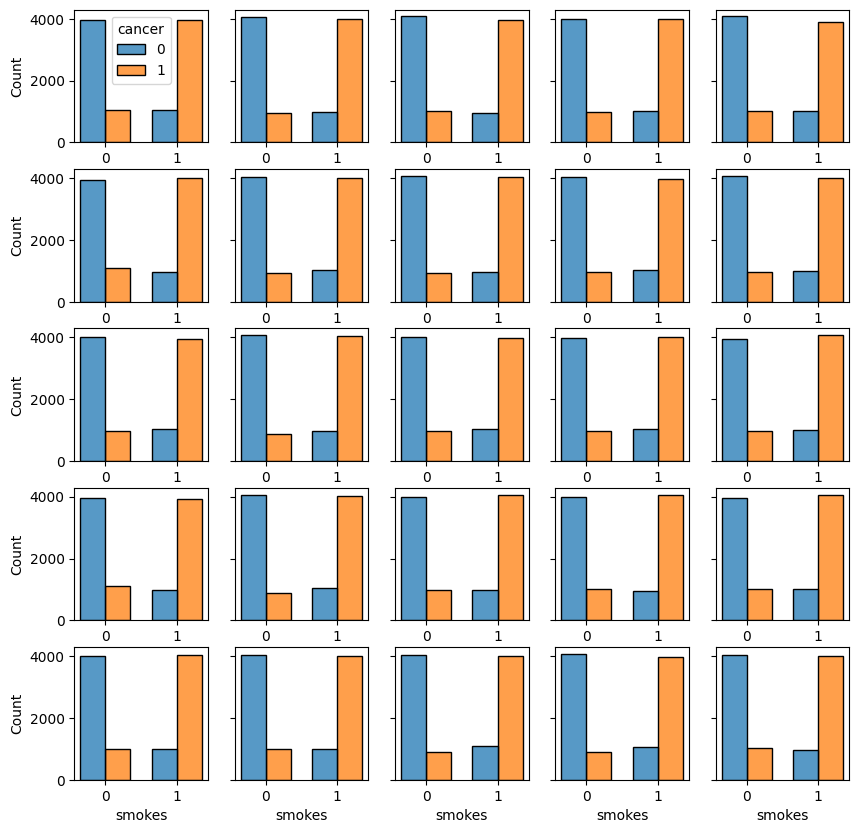

In [93]:
_, ax = plt.subplots(5, 5, sharey=True, figsize=(10,10))

predictive = pyro.infer.Predictive(twin_model_conditioned, guide=guide, num_samples=25, return_sites=("stress", "treatment_assignment", "cancer_unobserved"))

result = predictive(n_individuals)

for i in range(25):

    row = i % 5
    col = i // 5
    

    stress = result["stress"][i, 0, :]
    smokes = result["treatment_assignment"][i, 0, 0, :]
    cancer = result["cancer_unobserved"][i, 1, :]
    
    data = torch.concat((stress.reshape(-1, 1), smokes.reshape(-1, 1), cancer.reshape(-1, 1)), axis=-1)
    frame = pd.DataFrame(data.numpy(), columns=["stress", "smokes", "cancer"]).astype("category").replace({0:"0", 1:"1"})
    sns.histplot(x='smokes', hue='cancer', multiple="dodge", shrink=0.7, data=frame, ax=ax[row, col], legend = (False if i else True))


Once we have a causal model, what can we use it for? We briefly describe
several problem types that practitioners of causal inference may be
interested in solving (but do not claim that this is an exhaustive
list):

-   **Causal discovery.** Given data (either observational, or collected
    under experimental conditions, or both), infer the underlying causal
    model, from a class of possible models.

-   **Parameter estimation.** Given data (either observational, or
    collected under experimental conditions, or both), and a causal
    model with unknown parameters $\theta$, infer plausible values of
    $\theta$.

-   **Causal effect estimation.** Given data (either observational, or
    collected under experimental conditions, or both), and a causal
    model (possibly with unknown structure or parameters), estimate a
    *causal effect*, e.g. the Average Treatment Effect or the Individual
    Average Treatment Effect. Such queries are designed to answer
    questions like, "On average, how much better would a patient fare if
    they were given one medication vs. another?"

-   **Counterfactual prediction.** Given observed data, and a causal
    model (possibly with unknown structure or parameters), estimate a
    *counterfactual query*, designed to answer questions like, "Given
    what we know about this patient (including their observed health
    outcome), how would their outcome have differed had we treated them
    differently?"

All of these questions can be posed in a Bayesian framework. In particular, 
causal discovery, parameter estimation, causal effect estimation, and counterfactual prediction can be framed as Bayesian inference in appropriately specified generative models.


The quantities over which we have uncertainty are:

-   the structure of the true causal model,

-   the parameters of the true causal model, and

-   the values of any latent variables posited by the true causal model,
    for each subject in our dataset. (In the presence of experimental
    data, we are also uncertain about the latent variables posited by
    the intervened version of the true causal model, for each subject in
    the experimental dataset.)

We can express priors over these quantities, and likelihoods that relate
them to the observations. For example, suppose we are uncertain about
the true model structure $m$, and its unknown parameters $\theta$, as
well as the values of latent variables $x$, but we have observed $y$ for
a number of subjects, indexed $j = 1, \dots, N$. Then the likelihood for
$y_j$ is $p(y_j \mid m, \theta, x_j) = m_\theta(y_j \mid x_j)$. If we
also have observations $y'$ from an experimental setting modeled by
intervention $i$, then the likelihood is
$p(y'_j \mid m, \theta, x_j) = \text{intervene}(m_\theta, i)(y'_j \mid x_j)$.

Having expressed a prior and a likelihood, posterior inference can
recover causal structures $m$ and parameters $\theta$. Causal effects
and counterfactuals can be estimated by introducing additional variables
representing hypothetical *potential outcomes*. Such constructions might
usefully be automated by probabilistic programming languages, at which
point existing PPL inference machinery could be applied to estimating
the posterior.


TODO: Refactor how to talk about identifiability


Bayesian causal inference places identifiability on a principled continuum of irreducible causal uncertainty.

On the surface, to claim that causal reasoning can be encapsulated by
probabilistic computation appears to be in direct conflict with Pearl's
insistence that causal and statistical concepts be kept
separate [@pearl2001bayesian]. As Pearl describes them, statistical
concepts are those that summarize the distribution over observed
variables.

The probabilistic computations that we discuss in this
documentation are different in-kind from these assumption-free
summaries of data, in that we aim compute to probabilities of *latent*
causal structure, effects, and counterfactuals. In our proposed
approach, causal probabilistic programs play the role of causal
assumptions, relating observations to the latent causal quantities of
interest.

Casting causal inference as a particular instantiation of probabilistic
inference does not change the reality that many causal conclusions
cannot be unambiguously identified from data, regardless of sample size.
How much of the mutual information between treatment and outcome is
attributable to latent confounding? Does A cause B or does B cause A? If
C were c, what would have happened to D? Answers to all of these
questions are often ambiguous. 

Surprisingly, most existing formulations
of causal inference avoid quantifying these uncertainties, instead
abandoning problems in which latent causal quantities cannot be uniquely
inferred from data.[^2] Instead, the probabilistic programming approach
we espouse here enables users to express their assumptions, compute the
resulting uncertainty, be it irreducible or not, and then make decisions
accordingly.

## A Causal Bayesian Workflow